# Task 4 — Training with Explanations Alone (TEA)

This notebook implements **TEA** for the **background-biased Colored MNIST** dataset in this repo.

**Key constraints (from `task4/TEA/instructions.md`)**:
- Teacher: `ThreeLayerCNN` trained on **standard MNIST** with **cross-entropy** (only for teacher).
- Student: trained on **biased Colored MNIST** using **ONLY** multi-resolution **LRP-ε** heatmap matching loss.
- Explanation method: **LRP-ε with ε = 0.01** (mandatory).
- Multi-resolution heatmaps at **28×28 (input)**, **14×14 (after pool1)**, **7×7 (after pool2)**.
- Student sees the **original biased** image; teacher sees the **background-stripped** version.
- **No cross-entropy / no logits distillation / no representation distillation** for the student.

In [1]:
# --- Setup ---
from __future__ import annotations

import math
import os
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import math

torch.backends.cudnn.benchmark = True

def set_seed(seed: int = 0) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cpu


In [2]:
# --- Paths (robust repo root detection) ---
def find_repo_root(start: Optional[Path] = None) -> Path:
    start = (start or Path.cwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / "task0").exists() and (p / "task1").exists() and (p / "task4").exists():
            return p
    raise RuntimeError("Could not locate repo root (expected folders: task0/task1/task4).")

REPO_ROOT = find_repo_root()
COLORED_ROOT = REPO_ROOT / "task0" / "outputs" / "colored-mnist"

# Prefer the repo-provided MNIST cache in experiments/task01/data if present (matches instructions.md),
# otherwise fall back to data/torchvision (torchvision will download if needed).
_mnist_preferred = REPO_ROOT / "experiments" / "task01" / "data"
MNIST_ROOT = _mnist_preferred if (_mnist_preferred / "MNIST" / "raw").exists() else (REPO_ROOT / "data" / "torchvision")

OUT_DIR = REPO_ROOT / "task4" / "TEA" / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("REPO_ROOT:", REPO_ROOT)
print("COLORED_ROOT exists:", COLORED_ROOT.exists(), COLORED_ROOT)
print("MNIST_ROOT:", MNIST_ROOT)

REPO_ROOT: /home/bonda/Documents/precog_application/cv-task
COLORED_ROOT exists: True /home/bonda/Documents/precog_application/cv-task/task0/outputs/colored-mnist
MNIST_ROOT: /home/bonda/Documents/precog_application/cv-task/experiments/task01/data


## 1) Model (must match repo's `ThreeLayerCNN`)

In [3]:
# --- ThreeLayerCNN (matches task1/cnn.ipynb) ---
class ThreeLayerCNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        conv1_features = 8
        conv2_features = 16

        self.conv1 = nn.Conv2d(3, conv1_features, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(conv1_features, conv2_features, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(conv2_features * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu_fc = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu_fc(self.fc1(x))
        x = self.relu_fc(self.fc2(x))
        x = self.fc3(x)
        return x

# quick shape check
_m = ThreeLayerCNN()
_x = torch.randn(2, 3, 28, 28) # two random "images"
print('logits shape:', _m(_x).shape) # returning two outputs for 10 classes each, as expected

logits shape: torch.Size([2, 10])


## 2) Data pipeline (biased student input + background-stripped teacher input)

In [4]:
# --- Biased Colored MNIST dataset (from task0 outputs) ---
BASE_TRANSFORM = transforms.ToTensor()

def load_meta(root: Path, split: str) -> pd.DataFrame:
    path = root / split / 'labels.csv'
    if not path.exists():
        raise FileNotFoundError(f'{path} not found. Generate colored-mnist first.')
    meta = pd.read_csv(path)
    if 'filename' not in meta.columns or 'label' not in meta.columns:
        raise ValueError('labels.csv must contain columns: filename, label')
    meta['label'] = meta['label'].astype(int)
    return meta

def _load_rgb(root: Path, split: str, filename: str) -> torch.Tensor:
    path = root / split / 'images' / filename
    return BASE_TRANSFORM(Image.open(path).convert('RGB'))

class ColoredMNISTDataset(Dataset):
    def __init__(self, root: Path, split: str):
        assert split in {'train', 'test'}
        self.root = root
        self.split = split
        self.meta = load_meta(root, split)

    def __len__(self) -> int:
        return len(self.meta)

    def __getitem__(self, idx: int):
        row = self.meta.iloc[int(idx)]
        x = _load_rgb(self.root, self.split, str(row.filename))
        y = int(row.label)
        return x, y

def strip_background(x: torch.Tensor, threshold: float = 0.9) -> torch.Tensor:
    """Teacher preprocessing: digit-only on black background (per TEA instructions)."""
    gray = x.mean(dim=1, keepdim=True)
    mask = (gray > threshold).float()
    return x * mask

train_dataset = ColoredMNISTDataset(COLORED_ROOT, 'train')
test_dataset = ColoredMNISTDataset(COLORED_ROOT, 'test')

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

print('Train samples:', len(train_dataset))
print('Test samples:', len(test_dataset))

Train samples: 60000
Test samples: 10000


## 3) LRP-ε (ε = 0.01) + Multi-resolution heatmaps (28×28, 14×14, 7×7)

In [5]:
# --- LRP-ε implementation for ThreeLayerCNN ---
EPS = 0.01  # must be exactly 0.01 per instructions.md

# forming the denominator in LRP back prop formula to avoid instability near zero
def _stabilize(z: torch.Tensor, eps: float) -> torch.Tensor:
    # perturb in direction of sign of z by eps (avoid division instability near 0)
    return z + eps * torch.where(z >= 0, torch.ones_like(z), -torch.ones_like(z))


def lrp_epsilon_linear(
    x: torch.Tensor,
    weight: torch.Tensor,
    bias: Optional[torch.Tensor],
    R_out: torch.Tensor,
    *,
    eps: float,
    relu_gate: bool = False,
 ) -> torch.Tensor:
    """LRP-ε for a linear layer.

    If relu_gate=True, we assume a ReLU follows this linear layer in the forward pass,
    so we gate relevance to only active output neurons (z > 0). This avoids propagating
    relevance through neurons that are zeroed by ReLU (common source of smeared/degenerate maps).
    """
    z = F.linear(x, weight, bias) # first term in denominator of LRP formula
    if relu_gate:
        R_out = R_out * (z > 0).to(R_out.dtype)
    z = _stabilize(z, eps)
    s = R_out / z
    c = F.linear(s, weight.t(), None)
    return x * c


def lrp_epsilon_conv2d(
    x: torch.Tensor,
    weight: torch.Tensor,
    bias: Optional[torch.Tensor],
    R_out: torch.Tensor,
    *,
    stride=1,
    padding=0,
    dilation=1,
    groups=1,
    eps: float,
    relu_gate: bool = False,
 ) -> torch.Tensor:
    """LRP-ε for a conv layer.

    If relu_gate=True, we assume a ReLU follows this conv in the forward pass and gate
    relevance to active outputs only (z > 0).
    """
    z = F.conv2d(x, weight, bias, stride=stride, padding=padding, dilation=dilation, groups=groups)
    if relu_gate:
        R_out = R_out * (z > 0).to(R_out.dtype)
    z = _stabilize(z, eps)
    s = R_out / z
    c = F.conv_transpose2d(s, weight, bias=None, stride=stride, padding=padding, dilation=dilation, groups=groups)
    return x * c

# something to do with signalling the class we want to explain
def _one_hot_like_logits(logits: torch.Tensor, class_idx: torch.Tensor) -> torch.Tensor:
    out = torch.zeros_like(logits)
    out.scatter_(1, class_idx.view(-1, 1), 1.0)
    return out


def _to_heatmap(R: torch.Tensor) -> torch.Tensor:
    """Convert relevance tensor to a (signed) TEA heatmap (channel-sum, then L1-normalize by abs-sum)."""
    # R: (N,C,H,W) -> (N,H,W)
    hm = R.sum(dim=1) # raw element wise sum (elements are relevances of pixels in each channel, can be pos or neg)
    den = hm.abs().sum(dim=(1, 2), keepdim=True).clamp_min(1e-8) # sum of abs values
    return hm / den # divide to find how much each pixel contributed to the final relevance, normalized by total relevance


@dataclass
class MultiResHeatmaps:
    logits: torch.Tensor
    preds: torch.Tensor
    heatmaps: Dict[str, torch.Tensor]  # keys: input, pool1, pool2


def lrp_multires_three_layer_cnn(
    model: ThreeLayerCNN,
    x: torch.Tensor,
    *,
    eps: float = EPS,
    class_idx: Optional[torch.Tensor] = None,
 ) -> MultiResHeatmaps:
    """LRP-ε relevance for a chosen class + multi-resolution heatmaps.

    Critical detail: for layers followed by ReLU, we gate relevance to only active outputs (z > 0).
    Without this, relevance can flow through units that are zero in the forward pass, producing
    class-agnostic and overly similar heatmaps (TEA then fails to induce classification).
    """
    # Forward with maxpool indices (for relevance routing)
    x0 = x
    z1 = model.conv1(x0)
    a1 = model.relu1(z1)
    p1, idx1 = F.max_pool2d(a1, kernel_size=2, stride=2, return_indices=True)

    z2 = model.conv2(p1)
    a2 = model.relu2(z2)
    p2, idx2 = F.max_pool2d(a2, kernel_size=2, stride=2, return_indices=True)

    flat = p2.view(p2.size(0), -1)
    h1 = model.fc1(flat)
    h1a = model.relu_fc(h1)
    h2 = model.fc2(h1a)
    h2a = model.relu_fc(h2)
    logits = model.fc3(h2a)

    if class_idx is None: # default to explaining the predicted class
        class_idx = logits.argmax(dim=1)
    preds = class_idx.detach()

    # shape (N, num_classes), with 1.0 at the class we want to explain and 0.0 elsewhere
    onehot = _one_hot_like_logits(logits, class_idx)
    # Start relevance at the chosen output neuron (LRP-ε).
    R_logits = logits * onehot # setting up initial relevance to backprop from the chosen class output

    # Backprop relevance through linear layers (LRP-ε)
    # fc3 has no ReLU after it
    R_h2a = lrp_epsilon_linear(h2a, model.fc3.weight, model.fc3.bias, R_logits, eps=eps, relu_gate=False)
    # fc2 is followed by ReLU in forward (h2a = ReLU(h2))
    R_h1a = lrp_epsilon_linear(h1a, model.fc2.weight, model.fc2.bias, R_h2a, eps=eps, relu_gate=True)
    # fc1 is followed by ReLU in forward (h1a = ReLU(h1))
    R_flat = lrp_epsilon_linear(flat, model.fc1.weight, model.fc1.bias, R_h1a, eps=eps, relu_gate=True)
    R_p2 = R_flat.view_as(p2)

    # Unpool relevance (pool2) back to a2 shape
    R_a2 = F.max_unpool2d(R_p2, idx2, kernel_size=2, stride=2, output_size=a2.shape)

    # Conv2 is followed by ReLU in forward (a2 = ReLU(z2))
    R_p1 = lrp_epsilon_conv2d(
        p1,
        model.conv2.weight,
        model.conv2.bias,
        R_a2,
        stride=model.conv2.stride,
        padding=model.conv2.padding,
        dilation=model.conv2.dilation,
        groups=model.conv2.groups,
        eps=eps,
        relu_gate=True,
    )

    # Unpool relevance (pool1) back to a1 shape
    R_a1 = F.max_unpool2d(R_p1, idx1, kernel_size=2, stride=2, output_size=a1.shape)

    # Conv1 is followed by ReLU in forward (a1 = ReLU(z1))
    R_x0 = lrp_epsilon_conv2d(
        x0,
        model.conv1.weight,
        model.conv1.bias,
        R_a1,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        dilation=model.conv1.dilation,
        groups=model.conv1.groups,
        eps=eps,
        relu_gate=True,
    )

    H_input = _to_heatmap(R_x0)   # 28x28
    H_pool1 = _to_heatmap(R_p1)   # 14x14
    H_pool2 = _to_heatmap(R_p2)   # 7x7

    return MultiResHeatmaps(
        logits=logits,
        preds=preds,
        heatmaps={"input": H_input, "pool1": H_pool1, "pool2": H_pool2},
    )

## 4) Teacher: train on standard MNIST (CE only here), then freeze

In [6]:
# --- Teacher training on standard MNIST ---
teacher_path = OUT_DIR / 'teacher_weights.pt'

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # 1ch -> 3ch
]) 
mnist_train = datasets.MNIST(root=MNIST_ROOT, train=True, download=True, transform=mnist_transform)
mnist_test = datasets.MNIST(root=MNIST_ROOT, train=False, download=True, transform=mnist_transform)
mnist_train_loader = DataLoader(mnist_train, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

teacher = ThreeLayerCNN().to(device)

def eval_mnist(model: nn.Module) -> float:
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in mnist_test_loader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x).argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()
    return 100.0 * correct / max(total, 1)

if teacher_path.exists():
    teacher.load_state_dict(torch.load(teacher_path, map_location=device))
    print('Loaded teacher weights:', teacher_path)
else:
    print('Training teacher from scratch...')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(teacher.parameters(), lr=1e-2, momentum=0.9, weight_decay=0.0)
    epochs = 7
    for epoch in range(1, epochs + 1):
        teacher.train()
        running = 0.0
        for x, y in mnist_train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = teacher(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            running += loss.item()
        acc = eval_mnist(teacher)
        print(f'Epoch {epoch}/{epochs} | loss={running/len(mnist_train_loader):.4f} | test_acc={acc:.2f}%')
    torch.save(teacher.state_dict(), teacher_path)
    print('Saved teacher weights:', teacher_path)

# Freeze teacher
teacher.eval()
for p in teacher.parameters():
    p.requires_grad = False
print('Teacher MNIST test acc:', eval_mnist(teacher))

Loaded teacher weights: /home/bonda/Documents/precog_application/cv-task/task4/TEA/outputs/teacher_weights.pt


/home/bonda/Documents/precog_application/cv-task/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Teacher MNIST test acc: 97.68


## 5) Student: TEA training loop (ONLY explanation loss; no labels)

In [7]:
# --- TEA loss (multi-resolution) + Student training loop ---
def tea_distance(Hs: torch.Tensor, Ht: torch.Tensor) -> torch.Tensor:
    """Per-sample TEA distance (scale-invariant).
    Function do compute d(Hs,Ht) = ||Hs - Ht||_1 / sqrt(||Hs||_1 * ||Ht||_1) as given in TEA paper pg 19!!!
    Uses normalization by the geometric mean of L1 norms (per instructions).
    """
    # H*: (N,H,W)
    num = (Hs - Ht).abs().sum(dim=(1, 2))
    ns = Hs.abs().sum(dim=(1, 2)).clamp_min(1e-8)
    nt = Ht.abs().sum(dim=(1, 2)).clamp_min(1e-8)
    den = torch.sqrt(ns * nt).clamp_min(1e-8)
    return num / den


# final TEA loss function as quoted in paper, but implemented slightly differently since our images are 28x28 max
def tea_loss_multi_res(hs: Dict[str, torch.Tensor], ht: Dict[str, torch.Tensor]) -> torch.Tensor:
    """Sum TEA distance across required resolutions: input, pool1, pool2."""
    losses = []
    for k in ["input", "pool1", "pool2"]:
        losses.append(tea_distance(hs[k], ht[k]))
    return torch.stack(losses, dim=0).sum(dim=0).mean()


@torch.no_grad()
def evaluate_accuracy(model: nn.Module, loader: DataLoader, name: str) -> float:
    model.eval()
    correct = 0
    total = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        pred = model(x).argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    acc = 100.0 * correct / max(total, 1)
    print(f"{name} accuracy: {acc:.2f}%")
    return acc


def _init_student_weights(m: nn.Module) -> None:
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        # randomly but sensibly initialize student weights (important for training stability with LRP/TEA loss)
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        if m.bias is not None:
            nn.init.zeros_(m.bias)


def train_student_tea(
    *,
    epochs: int = 7,
    batch_size: int = 256,
    lr: float = 0.001,
    optimizer_name: str = "sgd",
    momentum: float = 0.9,
    weight_decay: float = 0.0,
    grad_clip_norm: Optional[float] = 5.0,
    max_batches_per_epoch: Optional[int] = None,
    background_threshold: float = 0.9,
    student_heatmap_class: str = "teacher",
    debug_first_batch: bool = False,
 ) -> ThreeLayerCNN:
    """Train student using ONLY TEA loss (no CE/logit/rep losses).

    Heatmap class choice:
    - student_heatmap_class='teacher': compare teacher-vs-student heatmaps for the SAME teacher-predicted class.
    - student_heatmap_class='student': student uses its own argmax class for heatmaps; teacher uses its argmax.
    """
    if student_heatmap_class not in {"teacher", "student"}:
        raise ValueError("student_heatmap_class must be 'teacher' or 'student'")

    local_train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )
    local_test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )

    student = ThreeLayerCNN().to(device)
    student.apply(_init_student_weights)
    if optimizer_name.lower() == "adam":
        optimizer = optim.Adam(student.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name.lower() == "sgd":
        optimizer = optim.SGD(student.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    else:
        raise ValueError("optimizer_name must be 'adam' or 'sgd'")

    for epoch in range(1, epochs + 1):
        student.train()
        running = 0.0
        num_steps = 0
        for b, (x_biased, _y_unused) in enumerate(local_train_loader):
            if max_batches_per_epoch is not None and b >= max_batches_per_epoch:
                break

            x_biased = x_biased.to(device)
            x_teacher = strip_background(x_biased, threshold=background_threshold)

            with torch.no_grad():
                teacher_logits = teacher(x_teacher)
                pred_t = teacher_logits.argmax(dim=1)
                ht = lrp_multires_three_layer_cnn(teacher, x_teacher, eps=EPS, class_idx=pred_t).heatmaps

            if student_heatmap_class == "teacher":
                hs = lrp_multires_three_layer_cnn(student, x_biased, eps=EPS, class_idx=pred_t).heatmaps
            else:
                hs_out = lrp_multires_three_layer_cnn(student, x_biased, eps=EPS, class_idx=None)
                hs = hs_out.heatmaps

            loss = tea_loss_multi_res(hs, ht)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            if grad_clip_norm is not None:
                torch.nn.utils.clip_grad_norm_(student.parameters(), grad_clip_norm)
            optimizer.step()

            running += float(loss.item())
            num_steps += 1

        avg = running / max(1, num_steps)
        print(f"[Student TEA] Epoch {epoch}/{epochs} | tea_loss={avg:.6f}")
        evaluate_accuracy(student, local_train_loader, "Easy train (biased)")
        evaluate_accuracy(student, local_test_loader, "Hard test (debiased)")

    return student

## 6) Run TEA training + save student weights

In [8]:
student_path = OUT_DIR / "student_weights.pt"

student = train_student_tea(
    epochs=7,
    batch_size=128,
    optimizer_name="sgd",
    lr=0.01,
    grad_clip_norm=5.0,
    background_threshold=0.9,
    student_heatmap_class="teacher",
    debug_first_batch=False,
 )

torch.save(student.state_dict(), student_path)
print("Saved student weights:", student_path)

[Student TEA] Epoch 1/7 | tea_loss=2.405577
Easy train (biased) accuracy: 21.94%
Hard test (debiased) accuracy: 19.17%
[Student TEA] Epoch 2/7 | tea_loss=1.971981
Easy train (biased) accuracy: 27.63%
Hard test (debiased) accuracy: 27.23%
[Student TEA] Epoch 3/7 | tea_loss=1.770715
Easy train (biased) accuracy: 60.63%
Hard test (debiased) accuracy: 60.38%
[Student TEA] Epoch 4/7 | tea_loss=1.620804
Easy train (biased) accuracy: 72.73%
Hard test (debiased) accuracy: 73.52%
[Student TEA] Epoch 5/7 | tea_loss=1.562040
Easy train (biased) accuracy: 78.06%
Hard test (debiased) accuracy: 78.66%
[Student TEA] Epoch 6/7 | tea_loss=1.534085
Easy train (biased) accuracy: 76.16%
Hard test (debiased) accuracy: 75.98%
[Student TEA] Epoch 7/7 | tea_loss=1.500590
Easy train (biased) accuracy: 86.98%
Hard test (debiased) accuracy: 86.87%
Saved student weights: /home/bonda/Documents/precog_application/cv-task/task4/TEA/outputs/student_weights.pt


## 7) Visual sanity checks (student heatmaps vs teacher targets)

[test] digit 0 | student heatmap stats: min=-0.0146 max=0.0466 mean=0.000998 sum=0.782
[test] digit 0 | teacher heatmap stats: min=-0.0305 max=0.0431 mean=0.000994 sum=0.779


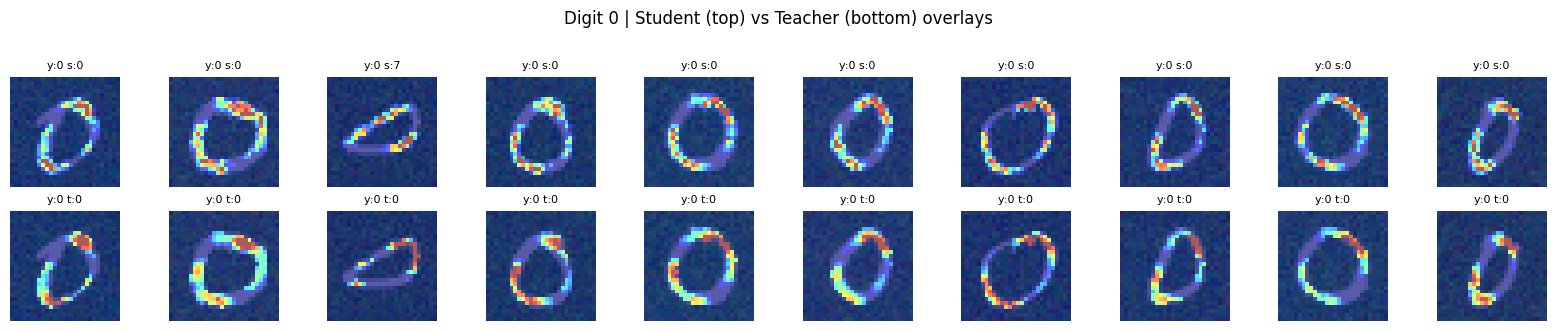

[test] digit 1 | student heatmap stats: min=-0.0178 max=0.0647 mean=0.00111 sum=0.872
[test] digit 1 | teacher heatmap stats: min=-0.0395 max=0.118 mean=0.00115 sum=0.905


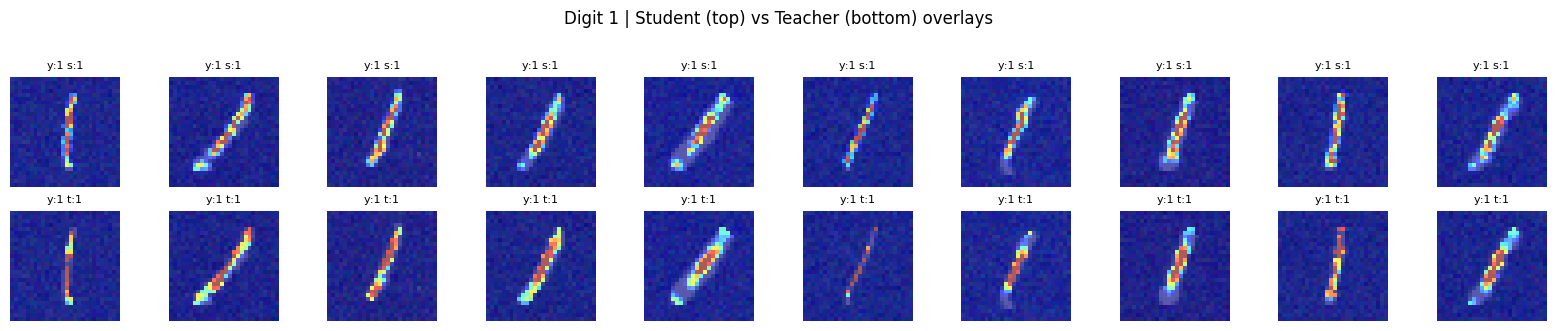

[test] digit 2 | student heatmap stats: min=-0.0195 max=0.0481 mean=0.000942 sum=0.739
[test] digit 2 | teacher heatmap stats: min=-0.0355 max=0.0493 mean=0.000928 sum=0.728


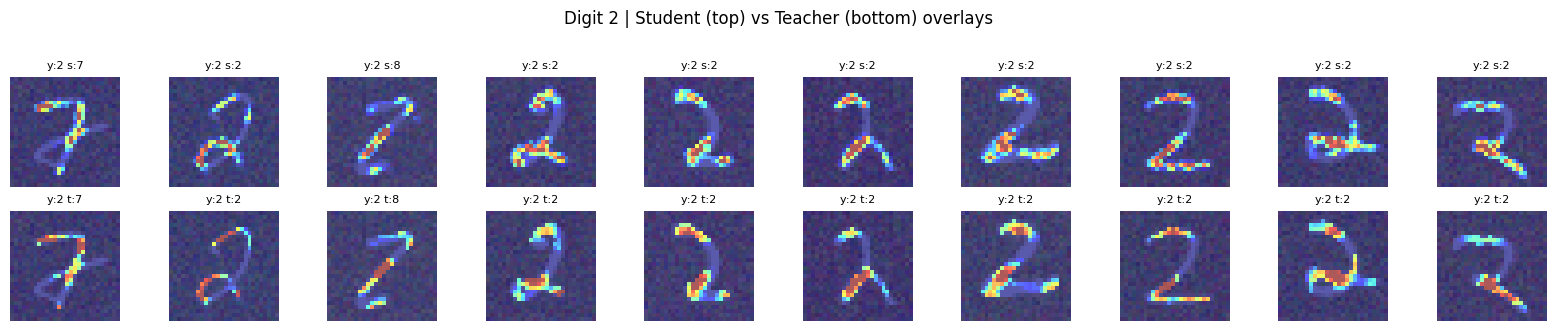

[test] digit 3 | student heatmap stats: min=-0.014 max=0.0615 mean=0.001 sum=0.786
[test] digit 3 | teacher heatmap stats: min=-0.0528 max=0.0522 mean=0.00107 sum=0.842


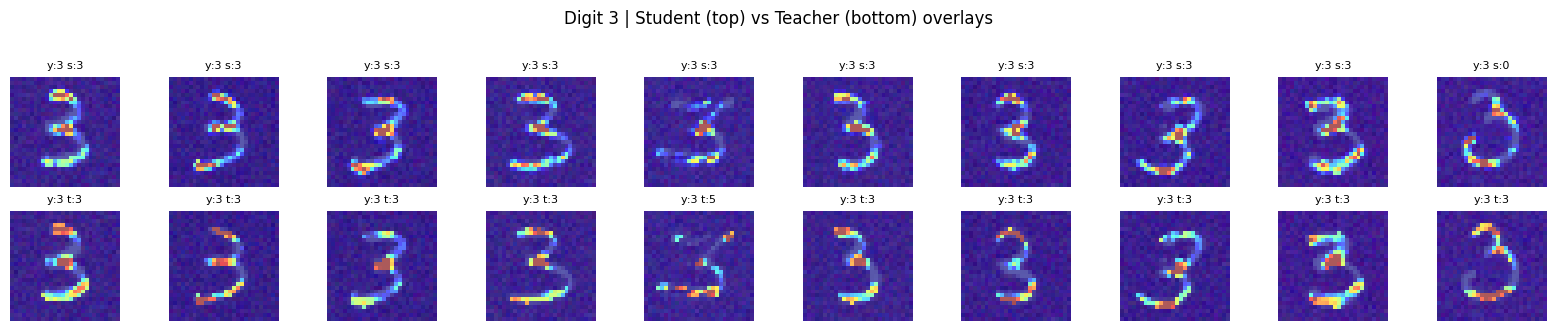

[test] digit 4 | student heatmap stats: min=-0.0274 max=0.0487 mean=0.000937 sum=0.735
[test] digit 4 | teacher heatmap stats: min=-0.0395 max=0.0541 mean=0.000923 sum=0.724


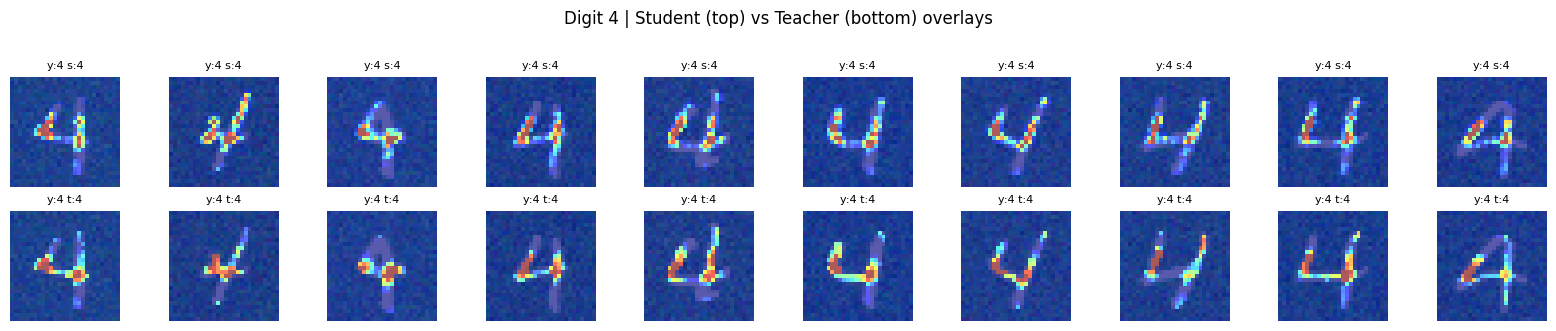

[test] digit 5 | student heatmap stats: min=-0.0284 max=0.0615 mean=0.000956 sum=0.75
[test] digit 5 | teacher heatmap stats: min=-0.0463 max=0.1 mean=0.000931 sum=0.73


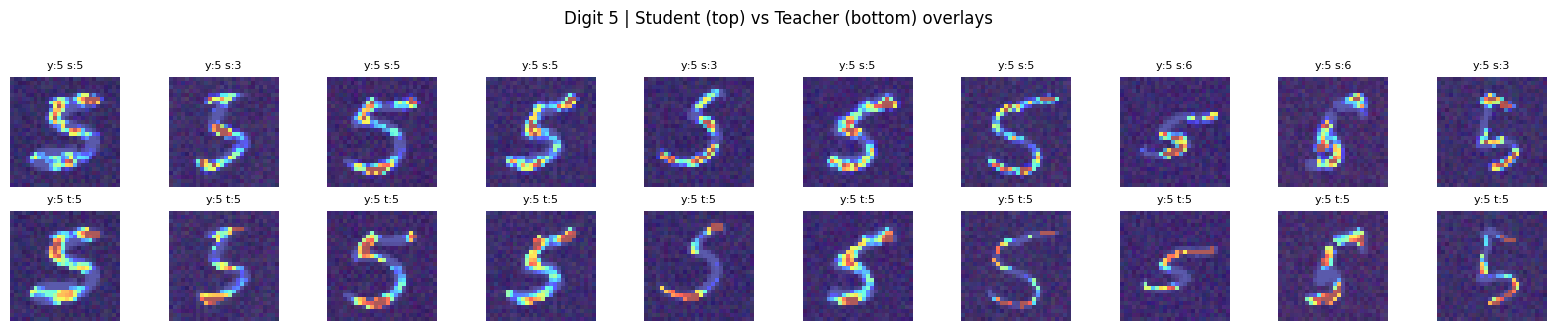

[test] digit 6 | student heatmap stats: min=-0.0274 max=0.0395 mean=0.000957 sum=0.75
[test] digit 6 | teacher heatmap stats: min=-0.0359 max=0.0396 mean=0.000887 sum=0.695


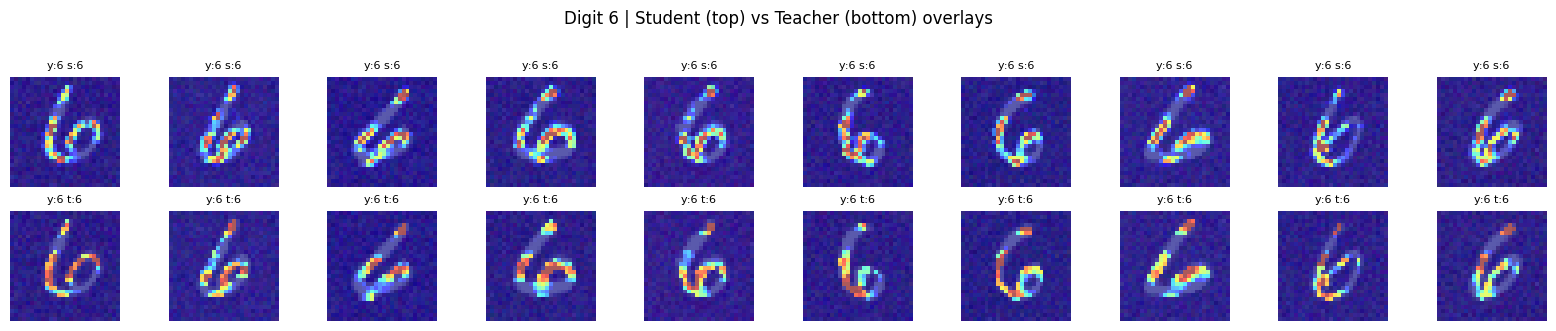

[test] digit 7 | student heatmap stats: min=-0.0478 max=0.0584 mean=0.00108 sum=0.847
[test] digit 7 | teacher heatmap stats: min=-0.0792 max=0.0605 mean=0.00105 sum=0.823


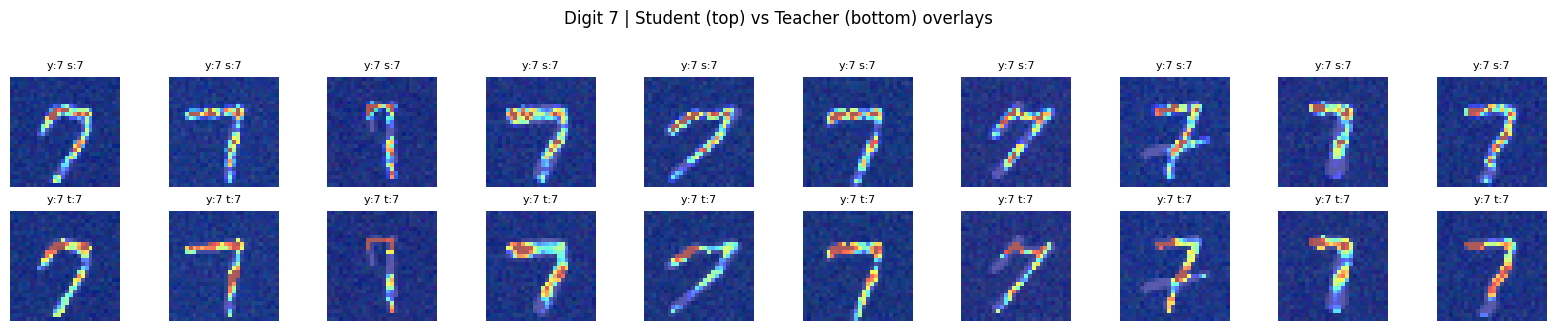

[test] digit 8 | student heatmap stats: min=-0.023 max=0.0735 mean=0.000892 sum=0.7
[test] digit 8 | teacher heatmap stats: min=-0.0486 max=0.0789 mean=0.000812 sum=0.636


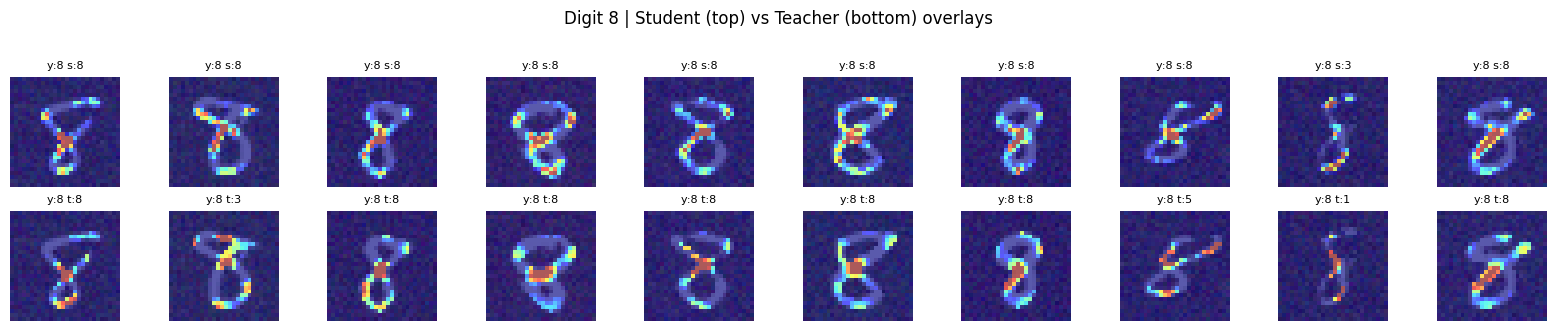

[test] digit 9 | student heatmap stats: min=-0.0285 max=0.0468 mean=0.00081 sum=0.635
[test] digit 9 | teacher heatmap stats: min=-0.0483 max=0.0464 mean=0.000787 sum=0.617


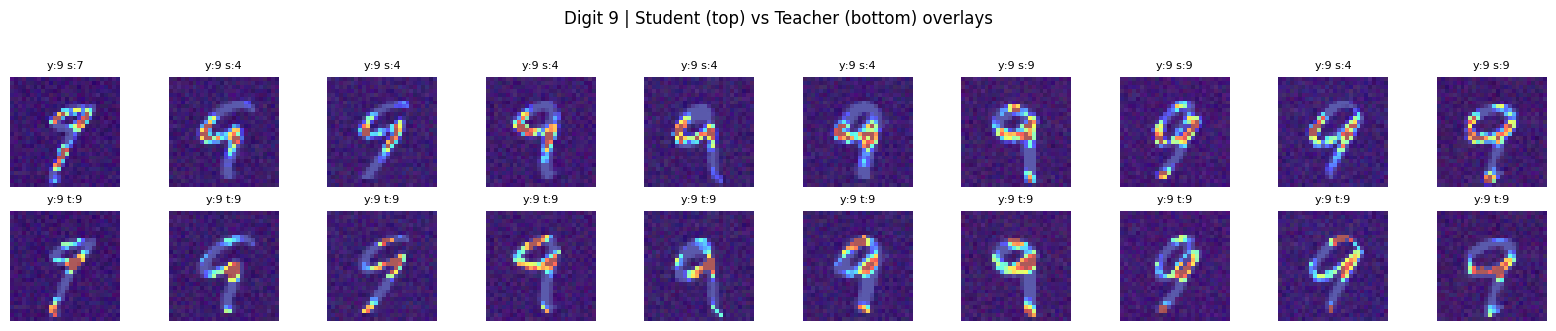

In [16]:
def collect_n_per_digit(dataset: ColoredMNISTDataset, n_per_digit: int = 10, seed: int = 0):
    rng = np.random.default_rng(seed)
    meta = dataset.meta.copy()
    chosen = {}
    for d in range(10):
        idxs = meta.index[meta["label"] == d].to_numpy()
        if len(idxs) == 0:
            chosen[d] = []
            continue
        pick = rng.choice(idxs, size=min(n_per_digit, len(idxs)), replace=False)
        chosen[d] = pick.astype(int).tolist()
    return chosen


def _hm_stats(hm: torch.Tensor) -> str:
    # hm: (N,H,W) on CPU
    return (
        f"min={hm.min().item():.3g} max={hm.max().item():.3g} "
        f"mean={hm.mean().item():.3g} sum={hm.sum(dim=(1,2)).mean().item():.3g}"
    )


def normalize_for_display(hm: torch.Tensor, *, q: float = 0.99) -> torch.Tensor:
    """Make heatmaps visually pop (does NOT affect training/loss).
    hm is expected to be non-negative."""
    # hm: (N,H,W)
    hm = hm.clamp_min(0)
    flat = hm.flatten(1)
    vmax = torch.quantile(flat, q, dim=1).clamp_min(1e-8).view(-1, 1, 1)
    return (hm / vmax).clamp(0, 1)


def _plot_two_row_overlays(
    images: torch.Tensor,
    hm_student: torch.Tensor,
    hm_teacher: torch.Tensor,
    *,
    digit: int,
    y_true: torch.Tensor,
    pred_student: torch.Tensor,
    pred_teacher: torch.Tensor,
    alpha: float = 0.65,
 ) -> None:
    # images: (N,3,28,28) cpu, heatmaps: (N,28,28) cpu (expected in [0,1])
    n = images.shape[0]
    if n == 0:
        print(f"No samples for digit {digit}")
        return
    fig, axes = plt.subplots(2, n, figsize=(1.6 * n, 3.2))
    if n == 1:
        axes = np.array([[axes[0]], [axes[1]]])
    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()
        # row 0: student overlay
        ax_s = axes[0, i]
        ax_s.imshow(img)
        ax_s.imshow(hm_student[i].numpy(), cmap="jet", alpha=alpha, vmin=0.0, vmax=1.0)
        ax_s.set_title(f"y:{int(y_true[i])} s:{int(pred_student[i])}", fontsize=8)
        ax_s.axis("off")
        # row 1: teacher overlay
        ax_t = axes[1, i]
        ax_t.imshow(img)
        ax_t.imshow(hm_teacher[i].numpy(), cmap="jet", alpha=alpha, vmin=0.0, vmax=1.0)
        ax_t.set_title(f"y:{int(y_true[i])} t:{int(pred_teacher[i])}", fontsize=8)
        ax_t.axis("off")
    axes[0, 0].set_ylabel("Student", fontsize=10)
    axes[1, 0].set_ylabel("Teacher", fontsize=10)
    fig.suptitle(f"Digit {digit} | Student (top) vs Teacher (bottom) overlays", y=1.02)
    plt.tight_layout()
    plt.show()


@torch.no_grad()
def show_student_teacher_per_digit(*, student: ThreeLayerCNN, split: str, n_per_digit: int = 10, seed: int = 0, threshold: float = 0.9):
    ds = train_dataset if split == "train" else test_dataset
    chosen = collect_n_per_digit(ds, n_per_digit=n_per_digit, seed=seed)
    student.eval()
    teacher.eval()
    for d in range(10):
        idxs = chosen.get(d, [])
        if len(idxs) == 0:
            continue
        xs, ys = [], []
        for i in idxs:
            x, y = ds[int(i)]
            xs.append(x)
            ys.append(int(y))
        x_cpu = torch.stack(xs, dim=0)
        y_cpu = torch.tensor(ys, dtype=torch.long)
        x = x_cpu.to(device)
        xt = strip_background(x, threshold=threshold)

        student_logits = student(x)
        teacher_logits = teacher(xt)
        pred_s = student_logits.argmax(dim=1).detach().cpu()
        pred_t = teacher_logits.argmax(dim=1).detach().cpu()

        ht = lrp_multires_three_layer_cnn(teacher, xt, eps=EPS, class_idx=pred_t.to(device)).heatmaps["input"].detach().cpu()
        hs = lrp_multires_three_layer_cnn(student, x, eps=EPS, class_idx=pred_s.to(device)).heatmaps["input"].detach().cpu()

        hs_disp = normalize_for_display(hs, q=0.99)
        ht_disp = normalize_for_display(ht, q=0.99)

        print(f"[{split}] digit {d} | student heatmap stats:", _hm_stats(hs))
        print(f"[{split}] digit {d} | teacher heatmap stats:", _hm_stats(ht))
        _plot_two_row_overlays(
            x_cpu,
            hs_disp,
            ht_disp,
            digit=d,
            y_true=y_cpu,
            pred_student=pred_s,
            pred_teacher=pred_t,
        )


#show_student_teacher_per_digit(student=student, split="train", n_per_digit=10, seed=0)
show_student_teacher_per_digit(student=student, split="test", n_per_digit=10, seed=1)